In [1]:
import pandas as pd

import data (Walmart Sales data)

In [8]:
df=pd.read_csv('./data/train.csv',parse_dates=['Date'])
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Basic checks

In [9]:
df.info()
df.isnull().sum()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


,Store,Dept,Date,Weekly_Sales
count,421570.000000,421570.000000,421570,421570.000000
mean,22.200546,44.260317,2011-06-18 08:30:31.963375104,15981.258123
min,1.000000,1.000000,2010-02-05 00:00:00,-4988.940000
25%,11.000000,18.000000,2010-10-08 00:00:00,2079.650000
50%,22.000000,37.000000,2011-06-17 00:00:00,7612.030000
75%,33.000000,74.000000,2012-02-24 00:00:00,20205.852500
max,45.000000,99.000000,2012-10-26 00:00:00,693099.360000
std,12.785297,30.492054,NaN,22711.183519


In [10]:
df.dtypes

Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
IsHoliday                 bool
dtype: object

Aggregate sales

In [11]:
weekly_sales=df.groupby('Date')['Weekly_Sales'].sum().sort_index()
weekly_sales

Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
                 ...     
2012-09-28    43734899.40
2012-10-05    47566639.31
2012-10-12    46128514.25
2012-10-19    45122410.57
2012-10-26    45544116.29
Name: Weekly_Sales, Length: 143, dtype: float64

plot sales trend

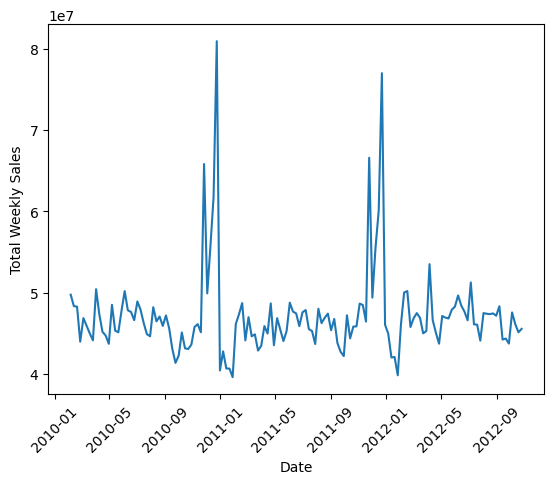

In [12]:
import matplotlib.pyplot as plt
plt.plot(weekly_sales)
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.xticks(rotation=45)
plt.show()

Big spikes repeat once every year.The timing of peaks is similar across years.
These spikes are not anomalies; they represent structural holiday effects that should be modeled, not removed.

Holiday impact

In [16]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()

IsHoliday
False    15901.445069
True     17035.823187
Name: Weekly_Sales, dtype: float64

TIME SERIES ANALYSIS

Prepare data for ARIMA/SARIMA

Stationarity Check

In [17]:
from statsmodels.tsa.stattools import adfuller

adf=adfuller(weekly_sales)
print('ADF statistics',adf[0])
print('p-value',adf[1])

ADF statistics -5.908297957186334
p-value 2.675979158986027e-07


Although Walmart sales show strong seasonal spikes due to holidays, the ADF test confirmed the series is stationary in terms of trend, so no non-seasonal differencing was required

d=0   D=1

ACF & PACF

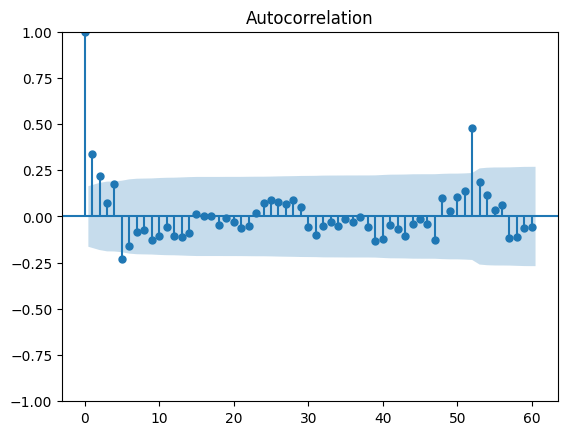

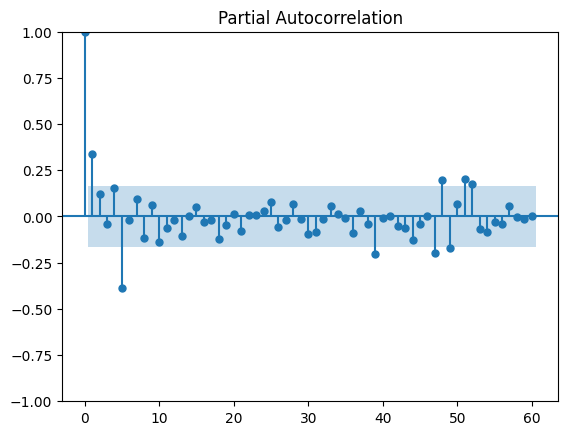

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(weekly_sales,lags=60)
plot_pacf(weekly_sales,lags=60)
plt.show()


In ACF plot lag 1 and 2 is significant-->last 2 week sale influence this week
Strong spike at lag 52-->same week last year matters-->yearly seasonality
q=1 or 2,Q=1

In PACF plot lag 1 is significant-->direct dependence on last week
seasonal influence at lag 52,but weaker than ACF
p=1,P->0 or 1

s=52

Final Model--> 
ARIMA(1,0,2)
SARIMA(1,0,2)(1,1,1,52)

Built statistical models

Train-Test Split

In [23]:
train=weekly_sales[:-12]
test=weekly_sales[-12:]

ARIMA Model

In [38]:
from statsmodels.tsa.arima.model import ARIMA

arima_model=ARIMA(train,order=(1,0,2))
arima_fit=arima_model.fit()
arima_fit.summary()

c:\Users\banu9\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\banu9\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\banu9\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  131
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -2208.021
Date:                Wed, 24 Dec 2025   AIC                           4426.042
Time:                        12:19:22   BIC                           4440.418
Sample:                    02-05-2010   HQIC                          4431.884
                         - 08-03-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        4.72e+07   1.55e-09   3.05e+16      0.000    4.72e+07    4.72e+07
ar.L1         -0.7359      0.086     -8.595      0.000      -0.904      -0.568
ma.L1          1.2125      0.085     14.190      0.000       1.045       1.380
ma.L2          0.5900      0.036     16.548      0.000       0.520       0.660
sigma2      2.843e+13   2.45e-15   1.16e+28      0.000    2.84e+13    2.84e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):               339.66
Prob(Q):                              0.50   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                             1.77
Prob(H) (two-sided):                  0.01   Kurtosis:                        10.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.36e+43. Standard errors may be unstable.
"""

In [39]:
arima_forecast=arima_fit.forecast(steps=len(test))

PLOT

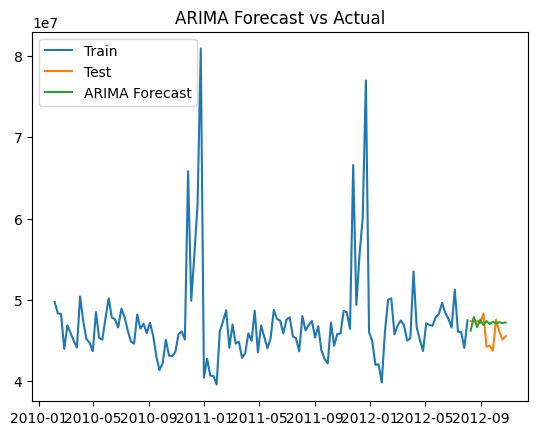

In [40]:

plt.figure()
plt.plot(train, label="Train")
plt.plot(test, label="Test")
plt.plot(arima_forecast, label="ARIMA Forecast")
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

SARIMA

In [45]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model=SARIMAX(train,order=(1,0,1),seasonal_order=(1,1,1,52))
sarima_fit=model.fit()
print(sarima_fit.summary())

c:\Users\banu9\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\banu9\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
c:\Users\banu9\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\banu9\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  wa

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  131
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 52)   Log Likelihood               -1259.234
Date:                            Wed, 24 Dec 2025   AIC                           2528.468
Time:                                    12:33:22   BIC                           2540.315
Sample:                                02-05-2010   HQIC                          2533.214
                                     - 08-03-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8751      0.289      3.032      0.002       0.309       1.441
ma.L1         -0.8772      0.281   

In [46]:
sarima_forecast=sarima_fit.forecast(steps=len(test))

PLOT

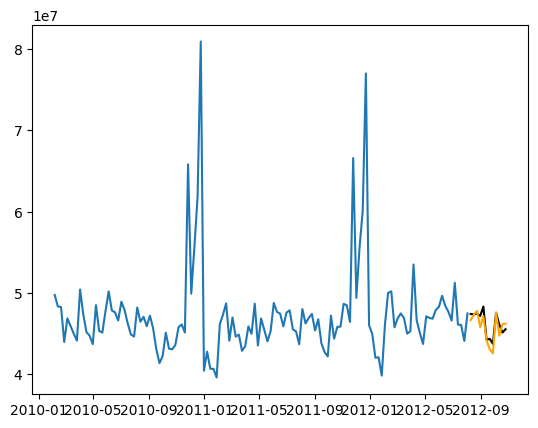

In [47]:
plt.plot(train,label='train')
plt.plot(test,label='Actual',color='black')
plt.plot(sarima_forecast,label='Forecast',color='orange')
plt.show()

Prophet Model

In [48]:
prophet_df=weekly_sales.reset_index()
prophet_df.columns=['ds','y']
prophet_df

,ds,y
0,2010-02-05,49750740.50
1,2010-02-12,48336677.63
2,2010-02-19,48276993.78
3,2010-02-26,43968571.13
4,2010-03-05,46871470.30
...,...,...
138,2012-09-28,43734899.40
139,2012-10-05,47566639.31
140,2012-10-12,46128514.25
141,2012-10-19,45122410.57


In [49]:
from prophet import Prophet
prophet_model=Prophet(yearly_seasonality=True,weekly_seasonality=False,daily_seasonality=False)
prophet_model.fit(prophet_df)

12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing


forecast

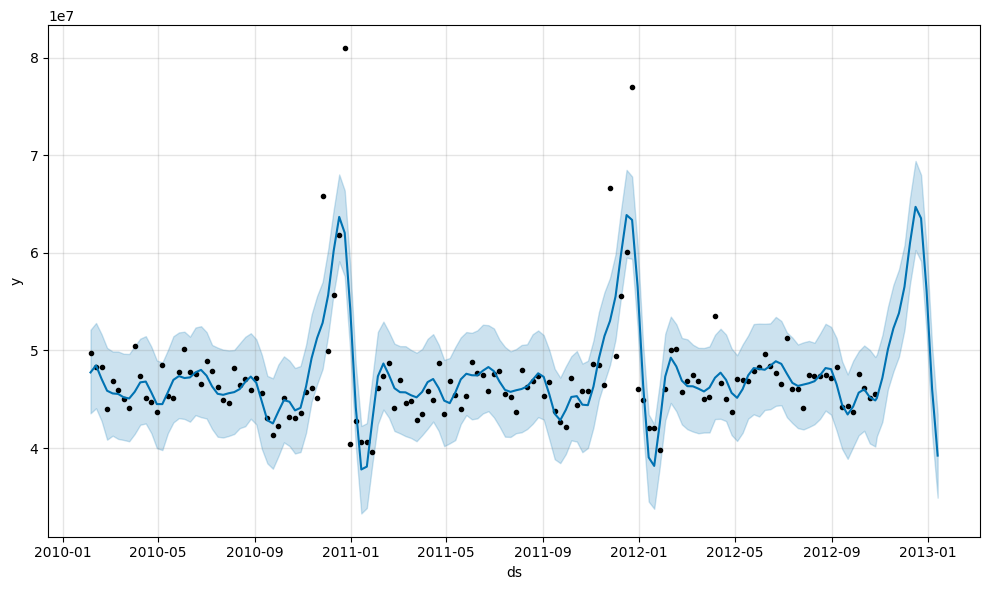

In [50]:
future=prophet_model.make_future_dataframe(periods=12,freq='W')
prophet_forecast=prophet_model.predict(future)
prophet_model.plot(prophet_forecast)
plt.show()

Model comparison

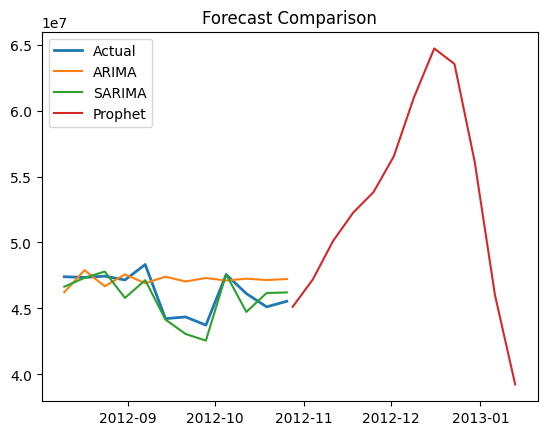

In [57]:
prophet_pred=prophet_forecast[['ds','yhat']].set_index('ds').iloc[-12:]#extracting prophet forecast with dates
plt.figure()
plt.plot(test, label="Actual", linewidth=2)
plt.plot(arima_forecast, label="ARIMA")
plt.plot(sarima_forecast, label="SARIMA")
plt.plot(prophet_pred.index,prophet_pred['yhat'], label="Prophet")
plt.legend()
plt.title("Forecast Comparison")
plt.show()


Prophet overestimated the trend and seasonal interaction in aggregated retail sales, leading to exaggerated forecasts. SARIMA performed better as it explicitly models seasonal dependencies without aggressive trend extrapolation.

In [51]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np

def evaluate(true,pred):
    return {
        'mae':mean_absolute_error(true,pred),
        'rmse':np.sqrt(mean_squared_error(true,pred))
    }

In [55]:
scores=[]

scores.append({
    'Model':'ARIMA',
    **evaluate(test,arima_forecast)
})
scores.append({
    'Model':'SARIMA',
    **evaluate(test,sarima_forecast)
})
scores.append({
    'Model':'Prophet',
    **evaluate(test,prophet_forecast['yhat'][-12:])
})
scores_df=pd.DataFrame(scores)
scores_df

,Model,mae,rmse
0,ARIMA,1.588545e+06,1.892971e+06
1,SARIMA,7.786006e+05,9.346303e+05
2,Prophet,8.234404e+06,1.053857e+07


SARIMA achieved the lowest MAE and RMSE, making it the most accurate model.
- ARIMA performed reasonably well but struggled with seasonal patterns.
- Prophet significantly underperformed due to the complex seasonal structure of retail sales.
- Yearly seasonality played a critical role in forecasting accuracy.
